In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np
import pathlib
import os
import shutil
import random
import matplotlib.pyplot as plt


# Base Class for Dataset Handling
class DataHandler:
    def __init__(self, dataset_url, subset_classes, images_per_class):
        self.data_dir = pathlib.Path(tf.keras.utils.get_file("food-101", origin=dataset_url, untar=True)) / "images"
        self.subset_data_dir = pathlib.Path("subset_food101")
        self.subset_classes = subset_classes
        self.images_per_class = images_per_class
        self.chosen_classes = []

    def prepare_dataset(self):
        if self.subset_data_dir.exists():
            shutil.rmtree(self.subset_data_dir)
        os.makedirs(self.subset_data_dir, exist_ok=True)

        self.chosen_classes = sorted(os.listdir(self.data_dir))[:self.subset_classes]
        for cls in self.chosen_classes:
            original_class_dir = self.data_dir / cls
            subset_class_dir = self.subset_data_dir / cls
            os.makedirs(subset_class_dir, exist_ok=True)

            images = os.listdir(original_class_dir)
            selected_images = random.sample(images, min(self.images_per_class, len(images)))

            for img in selected_images:
                shutil.copy(original_class_dir / img, subset_class_dir)
        print("Dataset prepared successfully.")

    def print_chosen_classes(self):
        print("Chosen Classes:")
        for idx, cls in enumerate(self.chosen_classes, start=1):
            print(f"{idx}. {cls}")


# Class for Training and Evaluating the Model
class ModelTrainer:
    def __init__(self, input_shape, subset_classes, batch_size):
        self.input_shape = input_shape
        self.subset_classes = subset_classes
        self.batch_size = batch_size
        self.model = None
        self.train_generator = None
        self.val_generator = None

    def create_generators(self, subset_data_dir):
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2
        )

        self.train_generator = train_datagen.flow_from_directory(
            subset_data_dir,
            target_size=self.input_shape[:2],
            batch_size=self.batch_size,
            class_mode="categorical",
            subset="training",
            shuffle=True
        )

        self.val_generator = train_datagen.flow_from_directory(
            subset_data_dir,
            target_size=self.input_shape[:2],
            batch_size=self.batch_size,
            class_mode="categorical",
            subset="validation"
        )

    def compute_class_weights(self):
        classes = self.train_generator.classes
        class_weights = class_weight.compute_class_weight(
            class_weight="balanced",
            classes=np.unique(classes),
            y=classes
        )
        return dict(enumerate(class_weights))

    def build_model(self):
        base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=self.input_shape)
        base_model.trainable = True

        inputs = layers.Input(shape=self.input_shape)
        x = base_model(inputs)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(2000, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(1500, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.subset_classes, activation="softmax")(x)

        self.model = Model(inputs, outputs)

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

    def print_model_summary(self):
        if self.model:
            self.model.summary()
        else:
            print("The model has not been built yet.")

    def train_model(self, epochs):
        class_weights = self.compute_class_weights()

        callbacks = [
            EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
            ModelCheckpoint("best_model.keras", save_best_only=True, verbose=1)
        ]

        history = self.model.fit(
            self.train_generator,
            validation_data=self.val_generator,
            epochs=epochs,
            class_weight=class_weights,
            callbacks=callbacks
        )
        return history

    def fine_tune_model(self, fine_tune_epochs):
        self.model.trainable = True

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        callbacks = [
            EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
            ModelCheckpoint("best_model_finetuned.keras", save_best_only=True, verbose=1)
        ]

        history = self.model.fit(
            self.train_generator,
            validation_data=self.val_generator,
            epochs=fine_tune_epochs,
            callbacks=callbacks
        )
        return history

    def save_model(self, filepath):
        self.model.save(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        self.model = tf.keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")

    def evaluate_model(self):
        loss, accuracy = self.model.evaluate(self.val_generator)
        print(f"Validation Loss: {loss:.4f}")
        print(f"Validation Accuracy: {accuracy:.4f}")


# Class for Visualization
class Visualizer:
    def __init__(self, calorie_mapping):
        self.calorie_mapping = calorie_mapping

    def predict_and_visualize_with_calories(self, model, generator, num_samples=10):
        test_images, test_labels = next(iter(generator))
        predictions = model.predict(test_images)
        predicted_classes = np.argmax(predictions, axis=1)

        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            plt.subplot(2, 5, i + 1)
            plt.imshow(test_images[i])

            true_class = list(generator.class_indices.keys())[list(generator.class_indices.values()).index(np.argmax(test_labels[i]))]
            pred_class = list(generator.class_indices.keys())[list(generator.class_indices.values()).index(predicted_classes[i])]

            predicted_calories = self.calorie_mapping.get(pred_class, "Calories Not Found")

            color = "green" if pred_class == true_class else "red"
            plt.title(f"True: {true_class}\nPred: {pred_class}\nCalories: {predicted_calories}", color=color)
            plt.axis("off")
        plt.tight_layout()
        plt.show()


# Usage
dataset_url = "https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"

calorie_mapping = {
    "apple_pie": 296,
    "baby_back_ribs": 484,
    "baklava": 334,
    "beef_carpaccio": 120,
    "beef_tartare": 230,
    "beet_salad": 150,
    "beignets": 389,
    "bibimbap": 490,
    "bread_pudding": 312,
    "breakfast_burrito": 290,
    "bruschetta": 170,
    "caesar_salad": 190,
    "cannoli": 216,
    "caprese_salad": 160,
    "carrot_cake": 330,
    "ceviche": 120,
    "cheese_plate": 400,
    "cheesecake": 257,
    "chicken_curry": 270,
    "chicken_quesadilla": 310,
    "chicken_wings": 430,
    "chocolate_cake": 235,
    "chocolate_mousse": 250,
    "churros": 116,
    "clam_chowder": 180,
    "club_sandwich": 275,
    "crab_cakes": 190,
    "creme_brulee": 300,
    "croque_madame": 560,
    "cup_cakes": 177,
    "deviled_eggs": 64,
    "donuts": 195,
    "dumplings": 230,
    "edamame": 120,
    "eggs_benedict": 300,
    "escargots": 200,
    "falafel": 333,
    "filet_mignon": 679,
    "fish_and_chips": 500,
    "foie_gras": 450,
    "french_fries": 312,
    "french_onion_soup": 120,
    "french_toast": 210,
    "fried_calamari": 290,
    "fried_rice": 250,
    "frozen_yogurt": 112,
    "garlic_bread": 206,
    "gnocchi": 200,
    "greek_salad": 160,
    "grilled_cheese_sandwich": 400,
    "grilled_salmon": 360,
    "guacamole": 230,
    "gyoza": 200,
    "hamburger": 354,
    "hot_and_sour_soup": 100,
    "hot_dog": 290,
    "huevos_rancheros": 220,
    "hummus": 166,
    "ice_cream": 137,
    "lasagna": 290,
    "lobster_bisque": 230,
    "lobster_roll_sandwich": 450,
    "macaroni_and_cheese": 300,
    "macarons": 100,
    "miso_soup": 40,
    "mussels": 150,
    "nachos": 346,
    "omelette": 200,
    "onion_rings": 400,
    "oysters": 95,
    "pad_thai": 350,
    "paella": 370,
    "pancakes": 175,
    "panna_cotta": 280,
    "peking_duck": 375,
    "pho": 400,
    "pizza": 266,
    "pork_chop": 250,
    "poutine": 650,
    "prime_rib": 670,
    "pulled_pork_sandwich": 310,
    "ramen": 436,
    "ravioli": 320,
    "red_velvet_cake": 293,
    "risotto": 360,
    "samosa": 250,
    "sashimi": 180,
    "scallops": 130,
    "seaweed_salad": 50,
    "shrimp_and_grits": 290,
    "spaghetti_bolognese": 310,
    "spaghetti_carbonara": 370,
    "spring_rolls": 200,
    "steak": 679,
    "strawberry_shortcake": 300,
    "sushi": 200,
    "tacos": 225,
    "takoyaki": 125,
    "tiramisu": 240,
    "tuna_tartare": 130,
    "waffles": 210,
}


In [ ]:
data_handler = DataHandler(dataset_url, subset_classes=101, images_per_class=1000)
data_handler.prepare_dataset()
data_handler.print_chosen_classes()

4996278331/4996278331 ━━━━━━━━━━━━━━━━━━━━ 261s 0us/step
Dataset prepared successfully.
Chosen Classes:
1. apple_pie
2. baby_back_ribs
3. baklava
4. beef_carpaccio
5. beef_tartare
6. beet_salad
7. beignets
8. bibimbap
9. bread_pudding
10. breakfast_burrito
11. bruschetta
12. caesar_salad
13. cannoli
14. caprese_salad
15. carrot_cake
16. ceviche
17. cheese_plate
18. cheesecake
19. chicken_curry
20. chicken_quesadilla
21. chicken_wings
22. chocolate_cake
23. chocolate_mousse
24. churros
25. clam_chowder
26. club_sandwich
27. crab_cakes
28. creme_brulee
29. croque_madame
30. cup_cakes
31. deviled_eggs
32. donuts
33. dumplings
34. edamame
35. eggs_benedict
36. escargots
37. falafel
38. filet_mignon
39. fish_and_chips
40. foie_gras
41. french_fries
42. french_onion_soup
43. french_toast
44. fried_calamari
45. fried_rice
46. frozen_yogurt
47. garlic_bread
48. gnocchi
49. greek_salad
50. grilled_cheese_sandwich
51. grilled_salmon
52. guacamole
53. gyoza
54. hamburger
55. hot_and_sour_soup
56.

In [ ]:
trainer = ModelTrainer(input_shape=(128, 128, 3), subset_classes=101, batch_size=64)
trainer.create_generators(data_handler.subset_data_dir)
trainer.build_model()


Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
trainer.print_model_summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 4, 4, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2000)                │       3,586,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1500)                │       3,001,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 101)                 │         151,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,412,924 (93.13 MB)

 Trainable params: 24,287,717 (92.65 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
history = trainer.train_model(epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.1402 - loss: 20.7035
Epoch 1: val_loss improved from inf to 3.05403, saving model to best_model.keras
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 785s 504ms/step - accuracy: 0.1403 - loss: 20.6961 - val_accuracy: 0.5108 - val_loss: 3.0540 - learning_rate: 1.0000e-04
Epoch 2/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5058 - loss: 2.7831
Epoch 2: val_loss improved from 3.05403 to 2.05381, saving model to best_model.keras
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 530s 418ms/step - accuracy: 0.5058 - loss: 2.7830 - val_accuracy: 0.5994 - val_loss: 2.0538 - learning_rate: 1.0000e-04
Epoch 3/10
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5945 - loss: 2.0531
Epoch 3: val_loss improved from 2.05381 to 1.81984, saving model to best_model.keras
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 531s 419ms/step - accuracy: 0.5945 - loss: 2.0530 - val_accuracy: 0.6428 - val_loss: 1.8198 - learning_rate: 1.0000e-04
Epoch 4/10
1263/1263 ━━━━━━━━━━━━━━

In [ ]:
fine_tune_history = trainer.fine_tune_model(fine_tune_epochs=8)

Epoch 1/8
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8242 - loss: 0.9396
Epoch 1: val_loss improved from inf to 1.35387, saving model to best_model_finetuned.keras
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 741s 479ms/step - accuracy: 0.8242 - loss: 0.9396 - val_accuracy: 0.7306 - val_loss: 1.3539 - learning_rate: 1.0000e-05
Epoch 2/8
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8370 - loss: 0.8495
Epoch 2: val_loss improved from 1.35387 to 1.32952, saving model to best_model_finetuned.keras
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 530s 417ms/step - accuracy: 0.8370 - loss: 0.8495 - val_accuracy: 0.7288 - val_loss: 1.3295 - learning_rate: 1.0000e-05
Epoch 3/8
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8407 - loss: 0.8139
Epoch 3: val_loss improved from 1.32952 to 1.30150, saving model to best_model_finetuned.keras
1263/1263 ━━━━━━━━━━━━━━━━━━━━ 525s 413ms/step - accuracy: 0.8407 - loss: 0.8139 - val_accuracy: 0.7363 - val_loss: 1.3015 - learning_rate: 1.0000e-05

In [ ]:
trainer.save_model("best_model_finetuned.keras")
trainer.evaluate_model()

Model saved to best_model_finetuned.keras
316/316 ━━━━━━━━━━━━━━━━━━━━ 105s 331ms/step - accuracy: 0.7353 - loss: 1.2982
Validation Loss: 1.2954
Validation Accuracy: 0.7360


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step


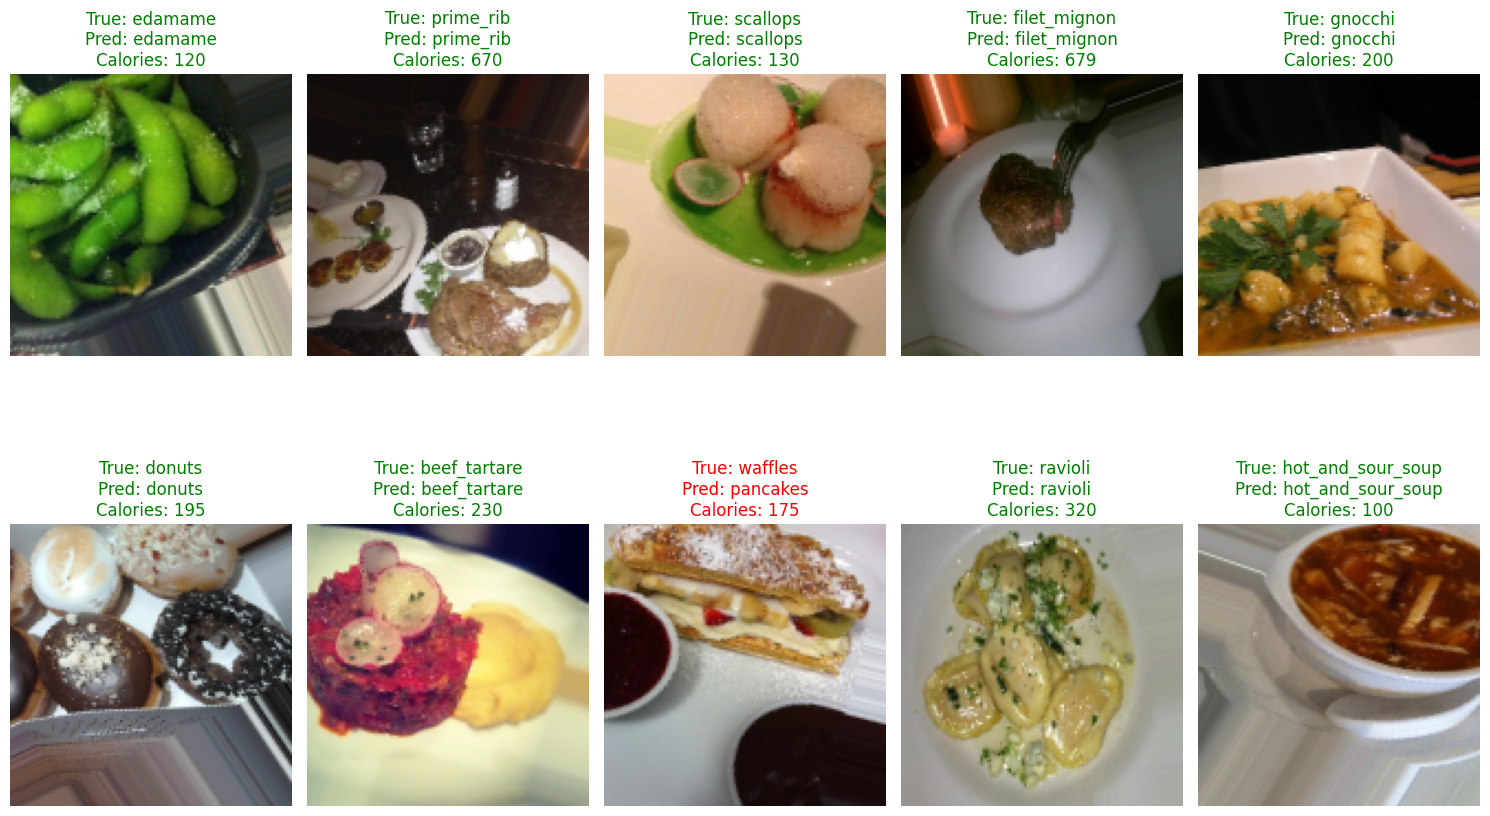

In [ ]:
visualizer = Visualizer(calorie_mapping)
visualizer.predict_and_visualize_with_calories(trainer.model, trainer.val_generator)

In [ ]:
from google.colab import files

files.download("best_model_finetuned.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>